# Task 8: Vision Transformer

Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.


#### What this notebook contains:
This notebook consists of:
- The code for a vision tranformer trained and tested on the MNIST dataset 
- The relevant theory for my proposal of a **Quantum Vision Transformer** in the end.

### Imports:
- We will use the bare minimum of libraries to build the Vision Transformer.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import os

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import layers

### Data preperation:

In this section, we shall:
- Load the data
- Tranform the data tensor to the right shapes
- Print the shapes 
- Create the train-val-test split

In [2]:
# Loading the MNIST data
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# See the shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# Adding an extra dimension to the labels to help with further prepocessing
y_train = tf.expand_dims(y_train,1)
y_test = tf.expand_dims(y_test,1)

# One hot encoded labels
train_lab = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
test_lab = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

In [4]:
# Creating the training and validation sets
from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, train_lab, test_size=0.20, 
                                                            random_state=42, shuffle = True) 

In [5]:
# Adding another dimension to the end of images to represent the number of channels
train_im = tf.expand_dims(train_im,3)
valid_im = tf.expand_dims(valid_im,3)
test_im= tf.expand_dims(x_test,3)

In [6]:
# Checking the shapes after the split
train_im.shape, valid_im.shape, train_lab.shape, valid_lab.shape, test_im.shape, test_lab.shape

(TensorShape([48000, 28, 28, 1]),
 TensorShape([12000, 28, 28, 1]),
 (48000, 10),
 (12000, 10),
 TensorShape([10000, 28, 28, 1]),
 (10000, 10))

In [7]:
# Augmenting the labels with its corresponding images
training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices((test_im, test_lab))

In [8]:
# Aliasing Autotune
autotune = tf.data.AUTOTUNE 

# Creating mini batches of our data
train_data_batches = training_data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)  

We will use convolution to create patches (as used in the original paper).

In [9]:
# Create a function to generate patches
def generate_patches(patch_size, hidden_size, inputs):
    """
    Generates patches of a given patch_size for an input image
    """
    patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    row_axis, col_axis = (1, 2)
    sequence_length = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
    x = tf.reshape(patches, [-1, sequence_length, hidden_size])
    return x



# Positonal Encoding Layer
class Positional_Encoding(layers.Layer):
    """
    Creates a layer that adds positional embeddings to the input patches.
    """

    def __init__(self, posemb_init=None, **kwargs):
        super().__init__(**kwargs)
        self.posemb_init = posemb_init
        

    def build(self, inputs_shape):
        pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
        self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)
        

    def call(self, inputs, inputs_positions=None):
        pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

        return inputs + pos_embedding

pos_embed_layer = Positional_Encoding(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))  

### Model Building
This section will involve the building of various components of the model and integrating them in the end. The hyperparameters used here are mainly from the original paper, however some may have been changed for convenience and reducing model complexity.

The input is fed into the positional embedding layer. Here the input won't have the <cls> token because we will make use of Global Average Pooling for classification in the last layers.
    
The encoder in a transformer has 2 main blocks:
- The MultiheadAttention block
- The Feedforward network block

There are intermediate Layer Normalization and Residual adder blocks and we implement them in between these two blocks. The next cell builds the functions for these blocks. 

In [10]:
def feed_forward_block(ann_dim, inputs):
    """ Returns a feed forward layer with the specified dimenstions and number of inputs"""
    x = layers.Dense(units=ann_dim, activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(rate=0.1)(x) 
    x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(rate=0.1)(x)
    
    return x


def Encoder_single_block(num_heads, ann_dim, inputs):
    """Returns a single block of encoder"""
    # The multiheadattention layer
    x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) 
    x = layers.Add()([x, inputs]) 
  
    # The dense layer
    y = layers.LayerNormalization(dtype=x.dtype)(x)
    y = feed_forward_block(ann_dim, y)
    y_1 = layers.Add()([y, x]) 
    
    return y_1


def Encoder(num_layers, ann_dim, num_heads, inputs):
    """Returns the whole encoder architecture with num_layers encoder blocks"""
    # Positional encoding
    x = Positional_Encoding(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
    x = layers.Dropout(rate=0.2)(x)
    
    # Repeating the transformers encoder block for num_layers times.
    for _ in range(num_layers):
        x = Encoder_single_block(num_heads, ann_dim, x)

    # Adding the final Layer norm layer
    encoded = layers.LayerNormalization(name='encoder_norm')(x)
    
    return encoded

In [11]:
# Declaring the Hyperparameters.
transformer_layers = 6
patch_size = 4
hidden_size = 64
num_heads = 4
ann_dim = 128

In [12]:
# We need to rescale the pixel values to the range [0,1]
rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

In [13]:
# Creating a function for building the Vision Transfomer
def Vision_Transformer():
    """Builds the Vision Transformer and returns the final model"""
    
    # Creating the Patches
    inputs = layers.Input(shape=train_im.shape[1:])
    rescale = rescale_layer(inputs)
    patches = generate_patches(patch_size, hidden_size, rescale)

    # Encoding
    encoder_out = Encoder(transformer_layers, ann_dim, num_heads, patches)  
    
    # Towards Classification
    GAP = tf.reduce_mean(encoder_out, axis=1)
    logits = layers.Dense(units=10, name='head', kernel_initializer=tf.keras.initializers.zeros)(GAP)
    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return final_model


# Calling an instance of the model
model = Vision_Transformer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 7, 7, 64)     1088        ['sequential[0][0]']             
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 49, 64)       0           ['conv2d[0][0]']                 
                                                                                              

                                                                  'add_4[0][0]']                  
                                                                                                  
 layer_normalization_6 (LayerNo  (None, 49, 64)      128         ['add_5[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 49, 64)      66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 49, 64)       0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
          

In [14]:
# Augmenting the training data to help with generalization

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_ds = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(10000).batch(32).prefetch(autotune))

In [15]:
# Compiling the model with Adam Optimizer, CategoricalCrossentropy as loss and Accuracy as the metric.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")) 

# Learning rate decrease
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5, verbose=1)

# Saving the model
checkpoint_path_1 = "ViT_60/cp-{epoch:04d}.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1, verbose=0, save_weights_only=True, save_freq=375)

# Fitting the model
model_train = model.fit(train_ds, 
                        epochs = 64, 
                        validation_data=valid_ds, 
                        callbacks=[reduce_lr,cp_callback])

Epoch 1/64
375/375 [==============================] - 548s 1s/step - loss: 1.4723 - accuracy: 0.4324 - val_loss: 0.9364 - val_accuracy: 0.6762 - lr: 0.0020
Epoch 2/64
375/375 [==============================] - 526s 1s/step - loss: 0.6511 - accuracy: 0.7871 - val_loss: 0.3620 - val_accuracy: 0.8855 - lr: 0.0020
Epoch 3/64
375/375 [==============================] - 523s 1s/step - loss: 0.3644 - accuracy: 0.8857 - val_loss: 0.2536 - val_accuracy: 0.9208 - lr: 0.0020
Epoch 4/64
375/375 [==============================] - 526s 1s/step - loss: 0.2778 - accuracy: 0.9115 - val_loss: 0.2453 - val_accuracy: 0.9233 - lr: 0.0020
Epoch 5/64
375/375 [==============================] - 508s 1s/step - loss: 0.2343 - accuracy: 0.9259 - val_loss: 0.1836 - val_accuracy: 0.9435 - lr: 0.0020
Epoch 6/64
375/375 [==============================] - 555s 1s/step - loss: 0.2064 - accuracy: 0.9344 - val_loss: 0.1670 - val_accuracy: 0.9494 - lr: 0.0020
Epoch 7/64
375/375 [==============================] - 495s 1s/st

Epoch 50/64
375/375 [==============================] - 589s 2s/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0706 - val_accuracy: 0.9818 - lr: 8.1920e-04
Epoch 51/64
375/375 [==============================] - 616s 2s/step - loss: 0.0246 - accuracy: 0.9911 - val_loss: 0.0714 - val_accuracy: 0.9803 - lr: 8.1920e-04
Epoch 52/64
375/375 [==============================] - 493s 1s/step - loss: 0.0260 - accuracy: 0.9910 - val_loss: 0.0712 - val_accuracy: 0.9811 - lr: 8.1920e-04
Epoch 53/64
375/375 [==============================] - 497s 1s/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0766 - val_accuracy: 0.9803 - lr: 8.1920e-04
Epoch 54/64
375/375 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9922
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0006553600542247295.
375/375 [==============================] - 492s 1s/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.0727 - val_accuracy: 0.9811 - lr: 8.1920e-04
Epoch 55/64
375/375 [============

### Analysis:

Now we will analyse how the various metrics pertaining to our model changed during training and also visualize them. In the end we will end with the evaluation of our model on the test set and plot a confusion matrix.

In [16]:
# Collecting the values from training history
loss = model_train.history['loss']
v_loss = model_train.history['val_loss']

acc = model_train.history['accuracy'] 
v_acc = model_train.history['val_accuracy']

epochs = range(len(loss))

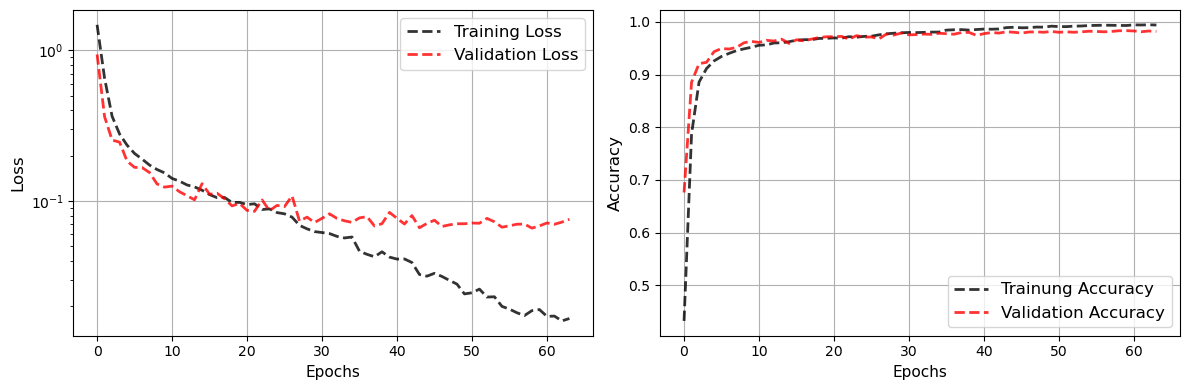

In [17]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Losses
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', lw=2, color='k', alpha=0.8, label='Training Loss')
plt.plot(epochs, v_loss, linestyle='--', lw=2, color='r', alpha=0.8, label='Validation Loss')
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', lw=2, color='k', alpha=0.8, label='Trainung Accuracy')
plt.plot(epochs, v_acc, linestyle='--', lw=2, color='r', alpha=0.8, label='Validation Accuracy') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid()

plt.tight_layout()
plt.show()

In [19]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(predictions): 
    """ 
    To plot the confusion matrix
    
    Params: 
    predictions: the evaluation on the test set

    """
    cm = confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1))
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [str(i) for i in range(10)], 
                yticklabels = [str(i) for i in range(10)], fmt="d")
    fig = sns_hmp.get_figure()

In [20]:
# Predicting for the test examples
pred_class = model.predict(x_test)

313/313 [==============================] - 27s 83ms/step


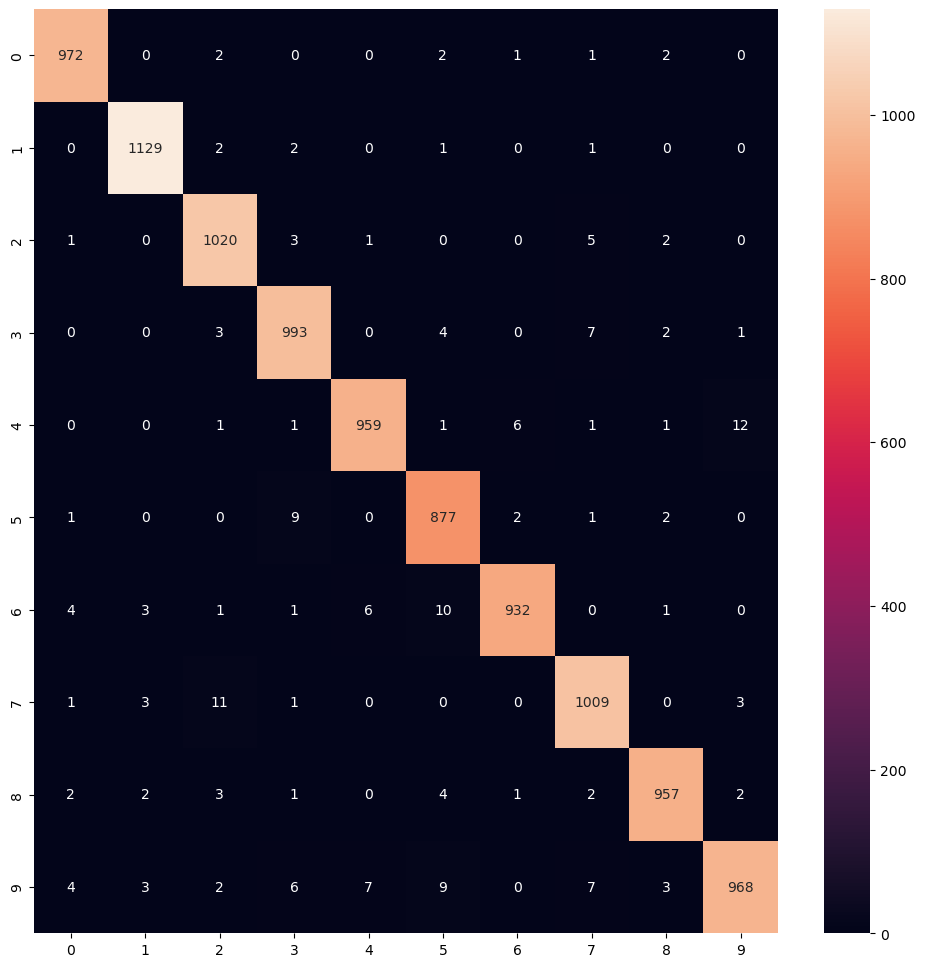

In [21]:
# Calling the function to plot the confusion matrix
conf_matrix(pred_class)

In [22]:
# Evaluating the metrics on the test data
loss, acc= model.evaluate(test_data_batches)

print("Evaluation Metrics for model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)

313/313 [==============================] - 26s 82ms/step - loss: 0.0769 - accuracy: 0.9826
Evaluation Metrics for model on Test Dataset
Loss: 0.07690183073282242
Accuracy: 0.9825999736785889


### Conclusion:
We trained a simple Classical Vision Transfomer on MNIST using tensorflow and ended up with a test accuracy of more than 98.25%. From the loss curves of training and validation sets, it is evident that the validation loss doesn't decrease after a certain point while the training loss decreases, which indicates that the model is overfitting to the training set. Generally Vision Transformers need a lot of data to have better performance than the state of the art CNN models. So this would work better with such problems where we have access to higher amount of data. We ended this up by plotting a confusion matrix to see what sort of classes are being majorly missclassified.

### References:
- [Keras example](https://keras.io/examples/vision/vit_small_ds/)
- [Original implementation](https://github.com/google-research/vision_transformer)

# My Idea for the Quantum Vision Transformer

### Why Quantum Vision Transformers?

We know the sort of revolutions Transformers have brought in the fields of Natural Language Processing and Computer Vision where data can be seen as a sequence. However the main issue is that the large number of parameters that they need. This causes several difficulties:
- Requirement of a huge dataset.
- Lot of computational resources.

So the problem needs to be solved for two primary reasons:
- Giving people with lesser computing resources an oppurtunity to work with them.
- Avoid the negative impacts of high energy consumption to the climate.

How Quantum Computers come with a promise to solve these issues in the future when they get accessible to people:
- Quantum Neural Networks require lesser training data to learn than their classical counterparts [ref](https://www.nature.com/articles/s41467-022-32550-3)
- Quantum Computers are expected to consume way less energy than their classical counterparts [ref](https://qz.com/1566061/quantum-computing-will-change-the-way-the-world-uses-energy)

Now with a motive in hand, I would like to chart out my plan for a Quantum Vision Transformer. I will propose a Quantum Classical (hybrid) model since I am considering we are going to implement this soon in the NISQ era itself. Later on, these ideas may be used to expand into a fully quantum version of the architecture.

### Patch Generation using Quantum Convolution:

The `generate_patches` function used in the above code used `Conv2D` layer in the process of generating patches. This could be replaced with a `QConv2D` layer where the `QConv2D` will implement the Quantum 2D convolution. Ideas for this layer can be borrowed and implemented from one of these papers:
- https://arxiv.org/abs/2012.12177
- https://arxiv.org/abs/1810.03787#
- https://arxiv.org/abs/1911.02998

There are several other papers that may be referred to. I will implement the layer which gives the best results on the validation dataset. The mentors may suggest their opinion too in helping with the circuit ansatz used in this layer.

The positional encoding will happen as it is and the output of this layer is fed into the next block.

### The Quantum Multi-head Attention:

I referred to the following 3 papers for the idea of calculating attention values:
- 1] https://arxiv.org/abs/2205.05625
- 2] https://arxiv.org/abs/2110.06510
- 3] https://arxiv.org/abs/2209.08167

Reference [2] proposes the use of VQCs to replace the learning of weights and that is what we shall do. But to calculate the values of attention- weights or $\alpha$s we will use a different technique over the traditional scaled dot product version. Reference [1] has critisized the use of extensions of inner product for the calculation of self attention. It rather uses the Gaussian projected quantum self-attention (GPQSA). I agree with their justification for using this and would therefore like to incorporate the original and a slightly modified version of this. 

The original idea is to measure one qubit to obtain the values of $<Z_q> and <Z_k>$ and use them in the expression $\alpha = e^{(<Z_q> - <Z_k>)^2}$. I will implement this.
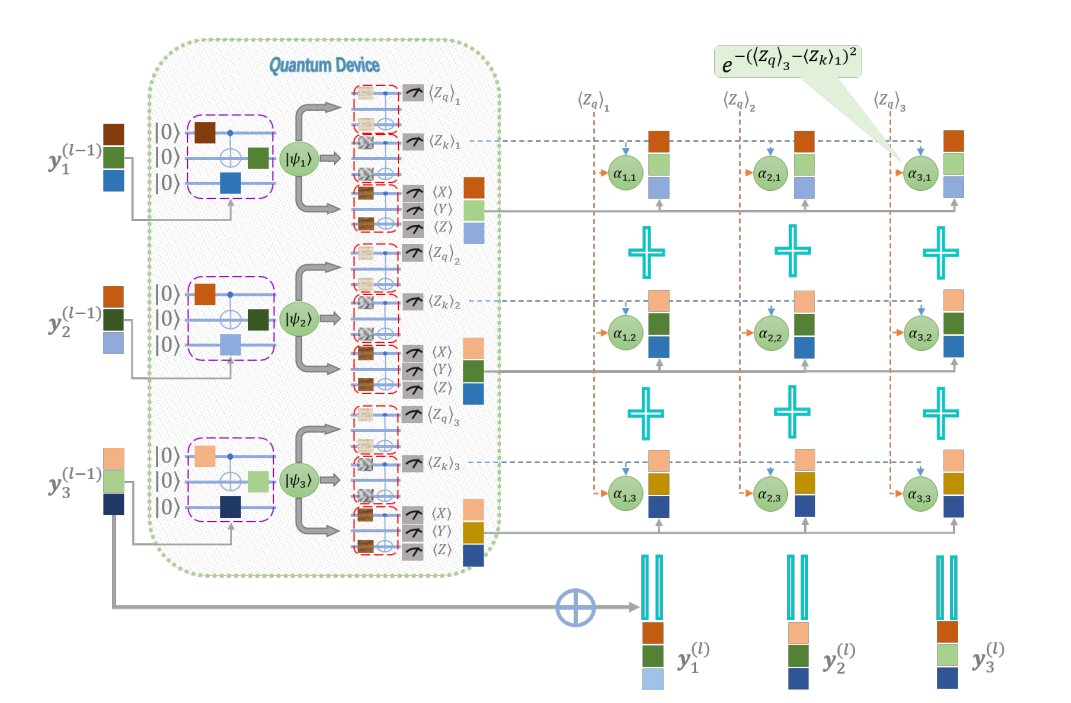
Img. source: Reference [1]

But I would like to also use a Novel Ansatz (my own idea) with controlled rotations to 3 qubit channels as shown here:
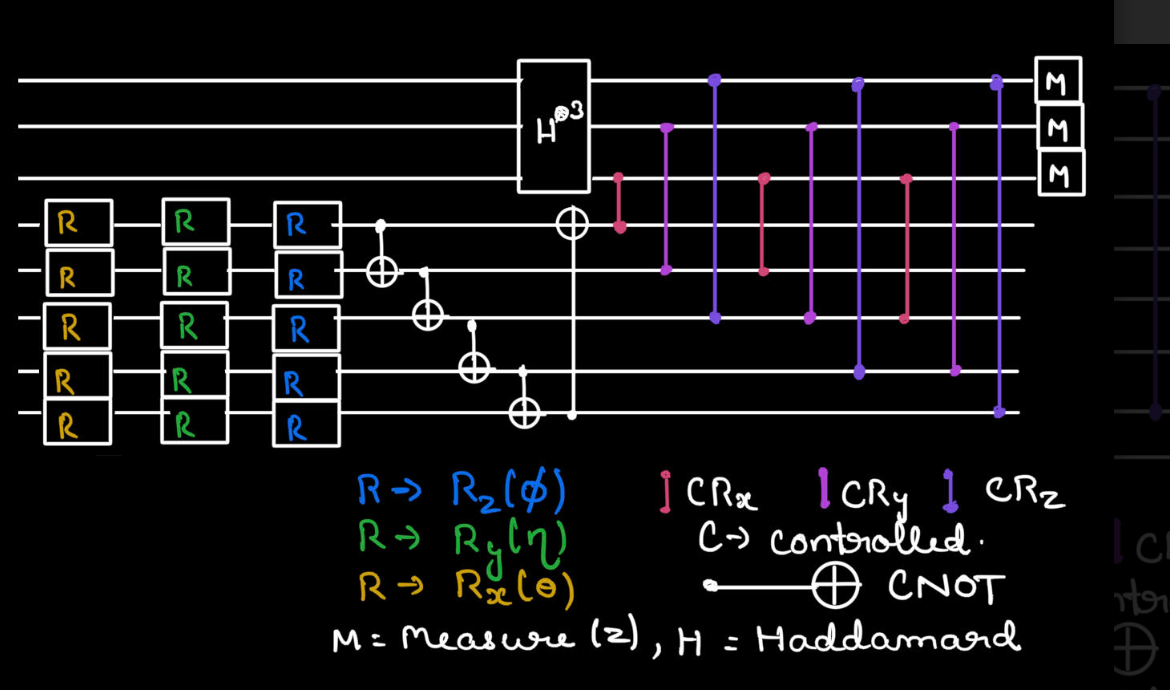
Here the parameters for the $R_x(\theta)$,  $R_y(\eta)$ and $R_z(\phi)$ and the 3 types of controlled rotations are to be learnt by the optimization procedure. My idea behind designing the Ansatz is to capture this sort of flavour of the three different types of rotations differently.


Then use these 3D vectors of measurement values $<Z_q> and <Z_k>$, to calculate the $\alpha$ values as follows: $e^{(<Z_q> - <Z_k>)^T(<Z_q> - <Z_k>)}$.

Now $\alpha$ calculated in both the implementations will be used with the value vector to calculate the final self attention values. Whichever will yield a better value will be finalized. The mentors may also suggest their opinions on desiging a better ansatz if required.

Now multiple heads of this attention will be concatenated to yield a QuantumMultiHeadAttention layer.

The model proposed in [2] also makes use of residual additions and so we shall keep that too. We may also experiment with the use of Layer Normalization. 

The datasets used by the reference [3] maybe then used to compare if this model can fare against theirs and prove to be better.

### The Feed forward block:

The Artificial Neural Network in this block may be replaced with a VQC with a suitable Ansatz. Since the focus is on NISQ era devices, I want to keep it hybrid and use some classical dense layers as well (along with the PQC layer).

We will experiment with keeping it purely classical or hybrid or purely quantum and use the version that gives the best results.

As followed in the original implementation, we will also make use of residual addition and Layer Normalization at the end of this block.

### Repeating these blocks:

The QuantumMultiHeadAttention and the feed forward block will be repleated for N times where N would be a hyperparameter to be determined with experimentation.

### Classification:
For Classification we shall use what we used in the code for the classical Vision Transfomer: We will use Global Average Pooling layer and use a softmax type classifier.

### Model Architecture Summary:


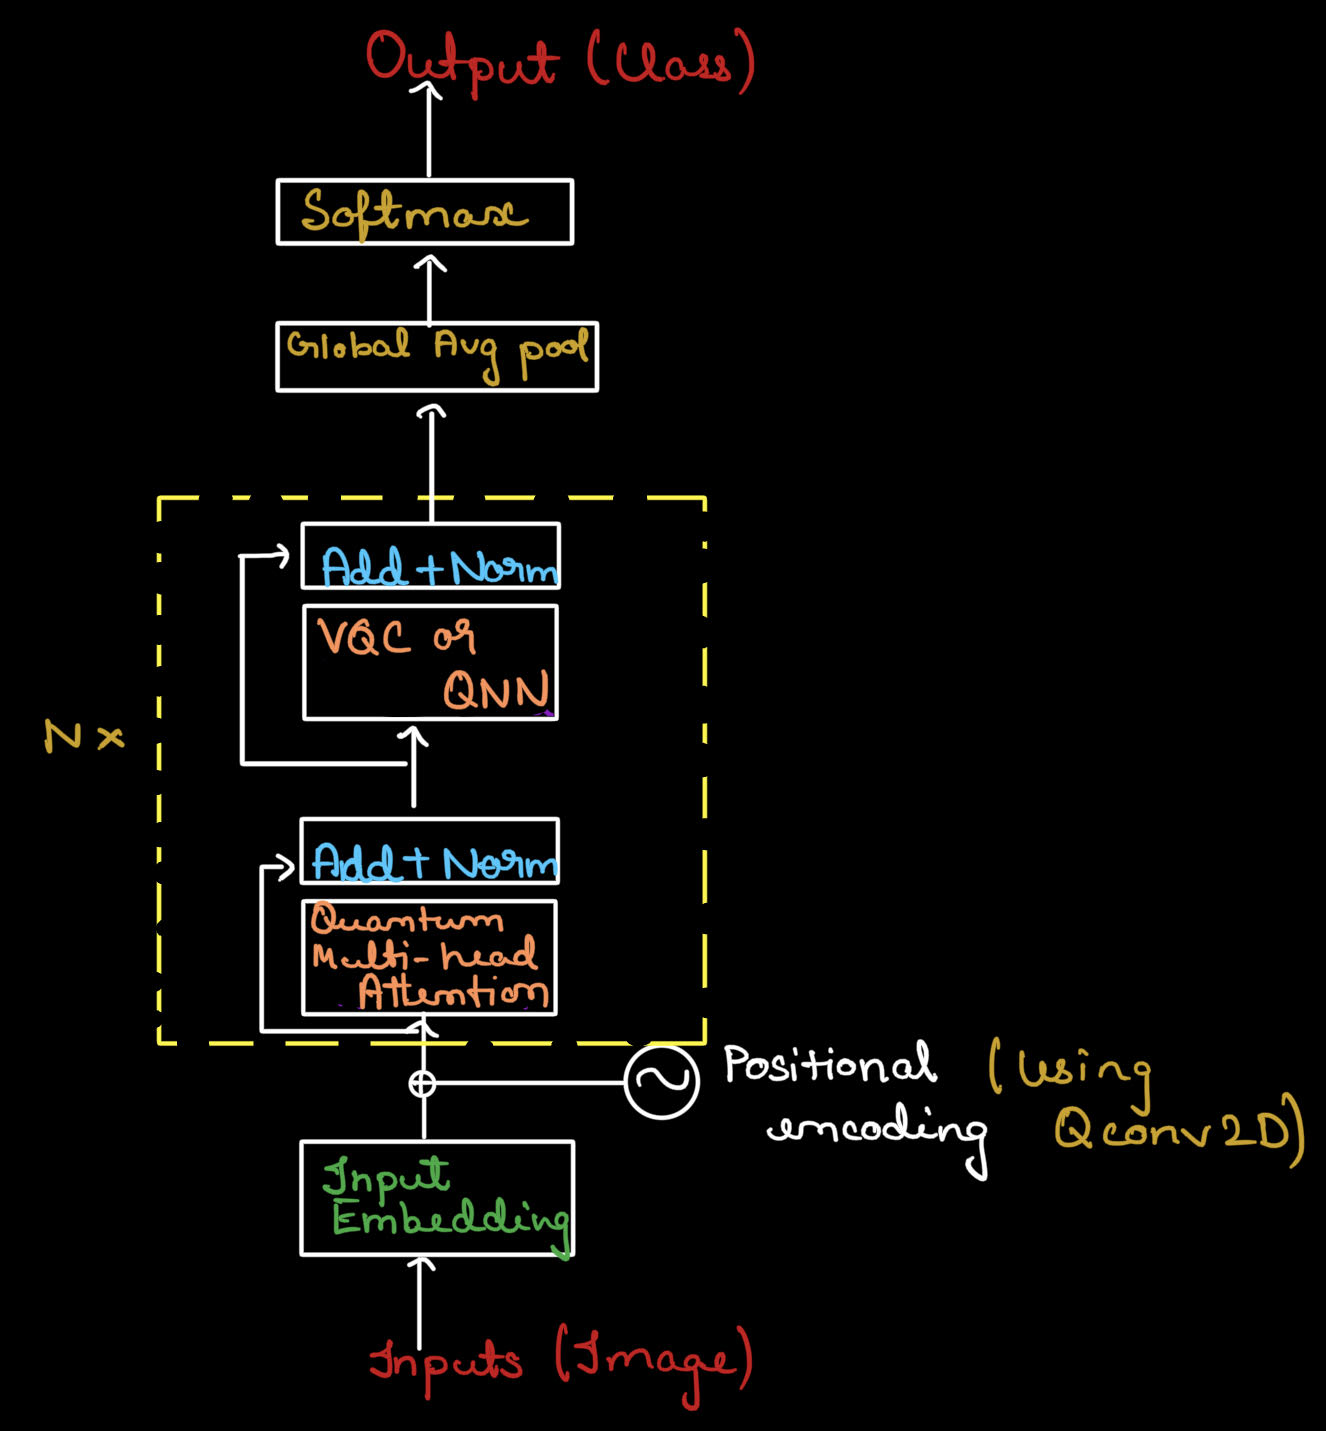